# 0. Instalacion de utilitarios Pyspark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz


In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


In [ ]:
!pip install pyspark

     |████████████████████████████████| 215.7MB 64kB/s 
     |████████████████████████████████| 204kB 37.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=d2edae82143657225b7443fd026d28af416c8451608171c4e7c2d905ae6ec0cf
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

# 1. Lectura del origen datos

In [ ]:
# Lectura desde un archivo fisico
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# Conexion al drive
#---------------------------
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.feature import VectorAssembler  
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls "/content/drive/My Drive/PySpark Machine Learning en plataforma Big Data/Training R ML en Casos de Negocios/2_caso negocio 2 riesgo crediticio"

'0. Caso negocio endeudamiento creditio.pptx'   2_DS_creditos.csv
'1_Diccionario credito.xls'


#2.  Cargando los datos en formato Spark

In [ ]:
df = spark.read.csv(
    '/content/drive/My Drive/PySpark Machine Learning en plataforma Big Data/Training R ML en Casos de Negocios/2_caso negocio 2 riesgo crediticio/2_DS_creditos.csv', 
    sep=',', header=True, inferSchema=True
)

# 2.1 Revision de formatos 
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: string (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: string (nullable = true)



In [ ]:
help(df.approxQuantile)

Help on method approxQuantile in module pyspark.sql.dataframe:

approxQuantile(col, probabilities, relativeError) method of pyspark.sql.dataframe.DataFrame instance
    Calculates the approximate quantiles of numerical columns of a
    DataFrame.
    
    The result of this algorithm has the following deterministic bound:
    If the DataFrame has N elements and if we request the quantile at
    probability `p` up to error `err`, then the algorithm will return
    a sample `x` from the DataFrame so that the *exact* rank of `x` is
    close to (p * N). More precisely,
    
      floor((p - err) * N) <= rank(x) <= ceil((p + err) * N).
    
    This method implements a variation of the Greenwald-Khanna
    algorithm (with some speed optimizations). The algorithm was first
    present in [[http://dx.doi.org/10.1145/375663.375670
    Space-efficient Online Computation of Quantile Summaries]]
    by Greenwald and Khanna.
    
    Note that null values will be ignored in numerical columns befo

In [ ]:
from pyspark.sql.functions import udf
@udf("int")
def replace_na(val):
  return -1 if str(val).lower() == 'na' or not str(val).isdigit() else int(val)

# display(df.select("id", squared_udf("id").alias("id_squared")))

df = df.withColumn(
    'Nro_dependiente', replace_na(df['Nro_dependiente']).cast('int')
).withColumn(
    'Mto_ingreso_mensual', replace_na(df['Mto_ingreso_mensual']).cast('int')
)

df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: integer (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: integer (nullable = true)



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd83556c5c0>]],
      dtype=object)

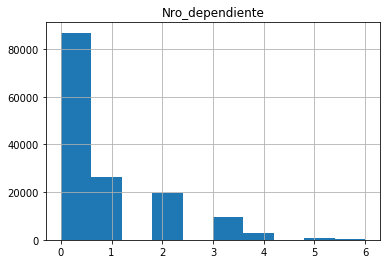

In [ ]:
df.filter(
    (df['Nro_dependiente'] >= 0) & (df['Nro_dependiente'] < 7)
).select('Nro_dependiente').toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd834f05470>]],
      dtype=object)

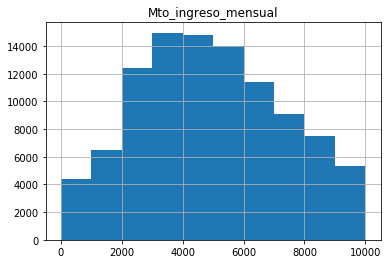

In [ ]:
df.filter(
    (df['Mto_ingreso_mensual'] >= 0) & (df['Mto_ingreso_mensual'] < 10000) 
).select('Mto_ingreso_mensual').toPandas().hist()

In [ ]:
median_dependienets = df.filter(
    df['Nro_dependiente'] >= 0
).select('Nro_dependiente').approxQuantile("Nro_dependiente", [0.5], 0.05)[0]

median_dependienets

0.0

In [ ]:
median_ingreso_mensual = df.filter(
    df['Mto_ingreso_mensual'] >= 0
).select('Mto_ingreso_mensual').approxQuantile("Mto_ingreso_mensual", [0.5], 0.05)[0]

median_ingreso_mensual

5333.0

In [ ]:
@udf("int")
def replace_negativos_dependienets(val):
  return int(median_dependienets) if val < 0 else val

@udf("int")
def replace_negativos_ingreso(val):
  return int(median_ingreso_mensual) if val < 0 else val

# display(df.select("id", squared_udf("id").alias("id_squared")))

df = df.withColumn(
    'Nro_dependiente', replace_negativos_dependienets(
        df['Nro_dependiente'].cast('int')
    )
).withColumn(
    'Mto_ingreso_mensual', replace_negativos_ingreso(
        df['Mto_ingreso_mensual'].cast('int')
    )
)

df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: integer (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: integer (nullable = true)



In [ ]:
# 2.2 Revvisiones  
df.show(5)

+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
| ID|Default|Prct_uso_tc|Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda|Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|Nro_dependiente|
+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
|  1|      1|0.766126609|  45|                     2|           0.802982129|               9120|                        13|                 0|                        6|                     0|              2|
|  2|      0|0.957151019|  40|                     0|           0.121876201|               2600|                         4|                 0|                        0|

In [ ]:
# 2.3 Validacion de carga del total de registros
print(df.count())

150000


In [ ]:
# 2.4 Exploracion inicial
df.describe().show()

+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+
|summary|                ID|            Default|       Prct_uso_tc|              Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda| Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|   Nro_dependiente|
+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+
|  count|            150000|             150000|            150000|            150000|                150000|                150000|             150000|                    150000|             1500

# 3. Limpieza e imputacion de variables con valores vacios


In [ ]:
# Proceso para identificar valores nulos en cada variables
# from pyspark.sql.functions import col,sum

#DS_Renovacion_prest.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in DS_Renovacion_prest.columns)).show()

#DS_Renovacion_prest.select(*(sum(col(c).isNull().cast("int")/87556).alias(c) for c in DS_Renovacion_prest.columns)).show()

In [ ]:
# Se identifico que hay 4 columnas con más de 5% de valores nulos
# USO_LINEA_TOTAL_TC_T2       67% nulos imputamos valores
# USO_TRIM_LINEA_BBVA         67% nulos imputamos valores
# SDO_CONSUMO_T2              18% nulos imputamos valores
# RESENCIA_OFERTA_PLD_RENOVADO 49% nulos imputamos valores

DS_Renovacion_prest.printSchema()



root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: string (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: string (nullable = true)



In [ ]:
# Habilitamos las funciones de Pyspark, es importante!
"""
from pyspark.sql.functions import *

DS_Renovacion_prest=DS_Renovacion_prest.withColumn(
    'USO_LINEA_TOTAL_TC_T2',
    when(DS_Renovacion_prest.USO_LINEA_TOTAL_TC_T2.isNull(), 0).otherwise(DS_Renovacion_prest.USO_LINEA_TOTAL_TC_T2)
)
DS_Renovacion_prest=DS_Renovacion_prest.withColumn(
    'USO_TRIM_LINEA_BBVA',
    when(DS_Renovacion_prest.USO_TRIM_LINEA_BBVA.isNull(), 0).otherwise(DS_Renovacion_prest.USO_TRIM_LINEA_BBVA)
)
DS_Renovacion_prest=DS_Renovacion_prest.withColumn(
    'SDO_CONSUMO_T2',
    when(DS_Renovacion_prest.SDO_CONSUMO_T2.isNull(), 0).otherwise(DS_Renovacion_prest.SDO_CONSUMO_T2)
)
DS_Renovacion_prest=DS_Renovacion_prest.withColumn(
    'RESENCIA_OFERTA_PLD_RENOVADO',
    when(DS_Renovacion_prest.RESENCIA_OFERTA_PLD_RENOVADO.isNull(), 0).otherwise(DS_Renovacion_prest.RESENCIA_OFERTA_PLD_RENOVADO)
)

#verificamos el reemplazamiento
DS_Renovacion_prest.describe().show()
"""

"\nfrom pyspark.sql.functions import *\n\nDS_Renovacion_prest=DS_Renovacion_prest.withColumn(\n    'USO_LINEA_TOTAL_TC_T2',\n    when(DS_Renovacion_prest.USO_LINEA_TOTAL_TC_T2.isNull(), 0).otherwise(DS_Renovacion_prest.USO_LINEA_TOTAL_TC_T2)\n)\nDS_Renovacion_prest=DS_Renovacion_prest.withColumn(\n    'USO_TRIM_LINEA_BBVA',\n    when(DS_Renovacion_prest.USO_TRIM_LINEA_BBVA.isNull(), 0).otherwise(DS_Renovacion_prest.USO_TRIM_LINEA_BBVA)\n)\nDS_Renovacion_prest=DS_Renovacion_prest.withColumn(\n    'SDO_CONSUMO_T2',\n    when(DS_Renovacion_prest.SDO_CONSUMO_T2.isNull(), 0).otherwise(DS_Renovacion_prest.SDO_CONSUMO_T2)\n)\nDS_Renovacion_prest=DS_Renovacion_prest.withColumn(\n    'RESENCIA_OFERTA_PLD_RENOVADO',\n    when(DS_Renovacion_prest.RESENCIA_OFERTA_PLD_RENOVADO.isNull(), 0).otherwise(DS_Renovacion_prest.RESENCIA_OFERTA_PLD_RENOVADO)\n)\n\n#verificamos el reemplazamiento\nDS_Renovacion_prest.describe().show()\n"

In [ ]:
# Limpiando de todos los valores nulos el data set

df = df.na.drop()
df.count()

150000

# 4. Exploracion de datos

In [ ]:
#4.2 Variable objetivo

print(DS_Renovacion_prest.count())
df.groupBy('Default').count().show()



150000
+-------+------+
|Default| count|
+-------+------+
|      1| 10026|
|      0|139974|
+-------+------+



# 5. Relevancia y transformacion de variables 

In [ ]:
# Consolidacion de variables
"""
cols_select = ['LINEA_RENOVADO','SUELDO_ESTIMADO','REGION_Vector', 'USO_TRIM_LINEA_BBVA', 
               'FLAG_LIMA_PROVINCIA','SUELDO_ESTIMADO', 'CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD',
               'REGION_Numerico', 'USO_LINEA_TOTAL_TC_T2', 'SDO_CONSUMO_T2', 'NR_ENTIDADES_TOTAL_T2',
               'DIFF_NRO_ENTIDA_TOTALES_T2_T12', 'RESENCIA_OFERTA_PLD_RENOVADO', 'Ahorro_Sldo_Bco_T1', 'PConsumo_Sldo_Bco_T1',
               'SDO_BCO_tot_sm_pasivo_Bco_6M'
              ]

import numpy as np
import pyspark.sql.functions as f


DS_Renovacion_prest = DS_Renovacion_prest.\
    withColumn('SUELDO_ESTIMADO_log', log('SUELDO_ESTIMADO')).\
    withColumn('ANTIGUEDAD_MES_log', log('ANTIGUEDAD_MES')).\
    withColumn('LINEA_RENOVADOS_log', log('LINEA_RENOVADO'))


DS_Renovacion_prest = DS_Renovacion_prest.withColumn(
    'SUELDO_ESTIMADO_log',
    when(DS_Renovacion_prest.SUELDO_ESTIMADO_log.isNull(), 0).otherwise(DS_Renovacion_prest.SUELDO_ESTIMADO_log)
).withColumn(
    'ANTIGUEDAD_MES_log',
    when(DS_Renovacion_prest.ANTIGUEDAD_MES_log.isNull(), 0).otherwise(DS_Renovacion_prest.ANTIGUEDAD_MES_log)
).withColumn(
    'LINEA_RENOVADOS_log',
    when(DS_Renovacion_prest.LINEA_RENOVADOS_log.isNull(), 0).otherwise(DS_Renovacion_prest.LINEA_RENOVADOS_log)
)

df_assembler = VectorAssembler(inputCols=cols_select + ['SUELDO_ESTIMADO_log', 'ANTIGUEDAD_MES_log', 'LINEA_RENOVADOS_log'], outputCol="features")

DS_Renovacion_prest = df_assembler.transform(DS_Renovacion_prest)
"""

'\ncols_select = [\'LINEA_RENOVADO\',\'SUELDO_ESTIMADO\',\'REGION_Vector\', \'USO_TRIM_LINEA_BBVA\', \n               \'FLAG_LIMA_PROVINCIA\',\'SUELDO_ESTIMADO\', \'CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD\',\n               \'REGION_Numerico\', \'USO_LINEA_TOTAL_TC_T2\', \'SDO_CONSUMO_T2\', \'NR_ENTIDADES_TOTAL_T2\',\n               \'DIFF_NRO_ENTIDA_TOTALES_T2_T12\', \'RESENCIA_OFERTA_PLD_RENOVADO\', \'Ahorro_Sldo_Bco_T1\', \'PConsumo_Sldo_Bco_T1\',\n               \'SDO_BCO_tot_sm_pasivo_Bco_6M\'\n              ]\n\nimport numpy as np\nimport pyspark.sql.functions as f\n\n\nDS_Renovacion_prest = DS_Renovacion_prest.    withColumn(\'SUELDO_ESTIMADO_log\', log(\'SUELDO_ESTIMADO\')).    withColumn(\'ANTIGUEDAD_MES_log\', log(\'ANTIGUEDAD_MES\')).    withColumn(\'LINEA_RENOVADOS_log\', log(\'LINEA_RENOVADO\'))\n\n\nDS_Renovacion_prest = DS_Renovacion_prest.withColumn(\n    \'SUELDO_ESTIMADO_log\',\n    when(DS_Renovacion_prest.SUELDO_ESTIMADO_log.isNull(), 0).otherwise(DS_Renovacion_prest.SUE

In [ ]:
df.columns

['ID',
 'Default',
 'Prct_uso_tc',
 'Edad',
 'Nro_prestao_retrasados',
 'Prct_deuda_vs_ingresos',
 'Mto_ingreso_mensual',
 'Nro_prod_financieros_deuda',
 'Nro_retraso_60dias',
 'Nro_creditos_hipotecarios',
 'Nro_retraso_ultm3anios',
 'Nro_dependiente']

In [ ]:
cols_slect =  ['Prct_uso_tc',
 'Edad',
 'Nro_prestao_retrasados',
 'Prct_deuda_vs_ingresos',
 'Mto_ingreso_mensual',
 'Nro_prod_financieros_deuda',
 'Nro_retraso_60dias',
 'Nro_creditos_hipotecarios',
 'Nro_retraso_ultm3anios',
 'Nro_dependiente']

In [ ]:
df_assembler = VectorAssembler(inputCols=cols_slect, outputCol="features")
df_model = df_assembler.transform(df).select('Default', 'features')
df_model.show()

+-------+--------------------+
|Default|            features|
+-------+--------------------+
|      1|[0.766126609,45.0...|
|      0|[0.957151019,40.0...|
|      0|[0.65818014,38.0,...|
|      0|(10,[0,1,3,4,5],[...|
|      0|[0.9072394,49.0,1...|
|      0|[0.213178682,74.0...|
|      0|[0.305682465,57.0...|
|      0|(10,[0,1,3,4,5],[...|
|      0|(10,[0,1,3,4,5],[...|
|      0|[0.189169052,57.0...|
|      0|(10,[0,1,3,4,5],[...|
|      0|[0.01879812,51.0,...|
|      0|[0.010351857,46.0...|
|      1|[0.964672555,40.0...|
|      0|(10,[0,1,3,5,7],[...|
|      0|[0.548458062,64.0...|
|      0|[0.061086118,78.0...|
|      0|(10,[0,1,3,4,5],[...|
|      0|[0.221812771,43.0...|
|      0|(10,[0,1,3,4,5],[...|
+-------+--------------------+
only showing top 20 rows



# 6. Entrenamiento del Algoritmo (Regresion Logistica)

In [ ]:
# Definicion de muestra de entrenamiento y Validacion

training_df, test_df = df_model.randomSplit([0.8,0.2], seed=1234)


In [ ]:
type(training_df), type(test_df)

(pyspark.sql.dataframe.DataFrame, pyspark.sql.dataframe.DataFrame)

In [ ]:
training_df.columns

['Default', 'features']

In [ ]:
test_df.columns

['Default', 'features']

In [ ]:
training_df.count(), test_df.count()

(120066, 29934)

In [ ]:
# Modelamiento de Regresion Logistica

from pyspark.ml.classification import LogisticRegression

log_reg = LogisticRegression(labelCol='Default').fit(training_df)

In [ ]:
# Revision
log_reg.coefficients

DenseVector([-0.0, -0.0289, 0.4922, -0.0, -0.0, -0.0072, 0.4728, 0.0711, -0.9334, 0.0892])

In [ ]:
# Aplicando sobre la data Train el modelo identificado

train_results = log_reg.evaluate(training_df).predictions
train_results.show()

+-------+--------------------+--------------------+--------------------+----------+
|Default|            features|       rawPrediction|         probability|prediction|
+-------+--------------------+--------------------+--------------------+----------+
|      0|(10,[0,1],[0.9999...|[1.99197959994322...|[0.8799524122158,...|       0.0|
|      0|(10,[0,1],[0.9999...|[2.19398218455622...|[0.89970780594262...|       0.0|
|      0|(10,[0,1],[0.9999...|[2.22283969664379...|[0.90228185596690...|       0.0|
|      0|(10,[0,1],[0.9999...|[2.28055472081893...|[0.90725373407715...|       0.0|
|      0|(10,[0,1],[0.9999...|[2.48255730543193...|[0.92290993982943...|       0.0|
|      0|(10,[0,1],[0.9999...|[3.29056764388392...|[0.96410380411938...|       0.0|
|      0|(10,[0,1],[0.9999...|[3.72343032519749...|[0.97641853559778...|       0.0|
|      0|(10,[0,1,2,3],[0....|[1.93268233246478...|[0.87354601637549...|       0.0|
|      0|(10,[0,1,2,3,4],[...|[1.45910444860743...|[0.81139566431992...|    

# 7. Evaluacion de poder predictivo

In [ ]:
# Aplicando el modelo predictivo

transformed = log_reg.transform(test_df)

In [ ]:
test_df.show(5)

+-------+--------------------+
|Default|            features|
+-------+--------------------+
|      0|(10,[0,1],[0.9999...|
|      0|(10,[0,1],[0.9999...|
|      0|(10,[0,1],[0.9999...|
|      0|(10,[0,1,2,3,4],[...|
|      0|(10,[0,1,2,3,4],[...|
+-------+--------------------+
only showing top 5 rows



In [ ]:
# Revision
transformed.show(3, False)

+-------+---------------------------+----------------------------------------+----------------------------------------+----------+
|Default|features                   |rawPrediction                           |probability                             |prediction|
+-------+---------------------------+----------------------------------------+----------------------------------------+----------+
|0      |(10,[0,1],[0.9999999,21.0])|[1.9054070636805098,-1.9054070636805098]|[0.8705022755019604,0.12949772449803962]|0.0       |
|0      |(10,[0,1],[0.9999999,22.0])|[1.934264575768081,-1.934264575768081]  |[0.8737206930312629,0.12627930696873718]|0.0       |
|0      |(10,[0,1],[0.9999999,22.0])|[1.934264575768081,-1.934264575768081]  |[0.8737206930312629,0.12627930696873718]|0.0       |
+-------+---------------------------+----------------------------------------+----------------------------------------+----------+
only showing top 3 rows



In [ ]:
# LLamando a las librerias de evaluacion de modelamiento

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed.select(['probability', 'Default'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

The ROC score is (@numTrees=200):  0.7083653784016744


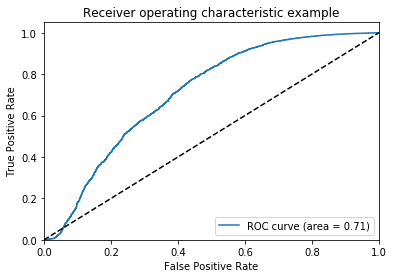

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#8. Aplicacion de modelos adicionales

##8.1 Algoritmo de Arbol de Clasficacion

In [ ]:
# Arbol de clasificacion

from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Default")
dt_model = dt.fit(training_df)

dt_prediction = dt_model.transform(test_df)

dt_prediction.select("prediction", "Default", "features").show()

+----------+-------+--------------------+
|prediction|Default|            features|
+----------+-------+--------------------+
|       0.0|      0|(10,[0,1],[0.9999...|
|       0.0|      0|(10,[0,1],[0.9999...|
|       0.0|      0|(10,[0,1],[0.9999...|
|       0.0|      0|(10,[0,1,2,3,4],[...|
|       0.0|      0|(10,[0,1,2,3,4],[...|
|       0.0|      0|(10,[0,1,2,3,4],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,4],[0....|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,9],[...|
+----------+-------+--------------

In [ ]:
# Reglas del arbol
#print(dt_model.toDebugString)

In [ ]:
# Evaluacion del poder predictivo del arbol
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Default", predictionCol="prediction", metricName="accuracy")

dt_accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTreeClassifier is = %g"% (dt_accuracy))
print("Test Error of DecisionTreeClassifier = %g " % (1.0 - dt_accuracy))


Accuracy of DecisionTreeClassifier is = 0.936594
Test Error of DecisionTreeClassifier = 0.0634062 


In [ ]:
# LLamando a las librerias de evaluacion de modelamiento

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = dt_prediction.select(['probability', 'Default'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

The ROC score is (@numTrees=200):  0.7999155004948348


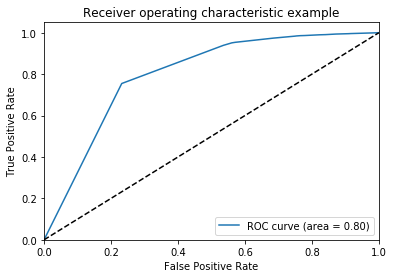

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##8.2 Algoritmo Random Forest

In [ ]:
# Aplicacion de Algoritmo Random Fores para modelamiento de clasificacion

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Default", numTrees=150)
rf_model = rf.fit(training_df)

rf_prediction = rf_model.transform(test_df)

rf_prediction.select("prediction", "Default", "features").show()

+----------+-------+--------------------+
|prediction|Default|            features|
+----------+-------+--------------------+
|       0.0|      0|(10,[0,1],[0.9999...|
|       0.0|      0|(10,[0,1],[0.9999...|
|       0.0|      0|(10,[0,1],[0.9999...|
|       0.0|      0|(10,[0,1,2,3,4],[...|
|       0.0|      0|(10,[0,1,2,3,4],[...|
|       0.0|      0|(10,[0,1,2,3,4],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,3,5],[...|
|       0.0|      0|(10,[0,1,2,4],[0....|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,5],[...|
|       0.0|      0|(10,[0,1,2,4,9],[...|
+----------+-------+--------------

In [ ]:
# LLamando a las librerias de evaluacion de modelamiento

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = rf_prediction.select(['probability', 'Default'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

The ROC score is (@numTrees=200):  0.8528853994294322


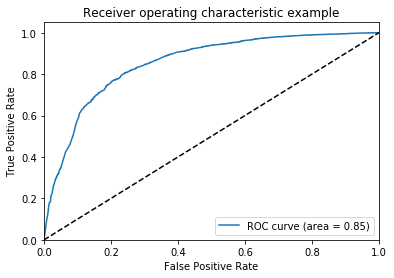

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Extra identificador de variables importantes
rf_model.featureImportances

SparseVector(10, {0: 0.1581, 1: 0.0115, 2: 0.1071, 3: 0.0049, 4: 0.0025, 5: 0.0071, 6: 0.4923, 7: 0.0031, 8: 0.2125, 9: 0.0009})